<a href="https://colab.research.google.com/github/JieShenAI/kaggle/blob/main/mli/d2l/house_price.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install jshen

In [ ]:
from j_torch.j_torch import load_array

In [ ]:
from j_torch import j_torch

In [ ]:
import hashlib
import os
import tarfile
import zipfile
import requests

DATA_HUB = dict()
DATA_URL = 'http://d2l-data.s3-accelerate.amazonaws.com/'

In [ ]:
def download(name, cache_dir=os.path.join('..', 'data')):
    """下载一个DATA_HUB中的文件，返回本地文件名"""
    assert name in DATA_HUB, f"{name} 不存在于 {DATA_HUB}"
    url, sha1_hash = DATA_HUB[name]
    os.makedirs(cache_dir, exist_ok=True)
    fname = os.path.join(cache_dir, url.split('/')[-1])
    if os.path.exists(fname):
        sha1 = hashlib.sha1()
        with open(fname, 'rb') as f:
            while True:
                data = f.read(1048576)
                if not data:
                    break
                sha1.update(data)
        if sha1.hexdigest() == sha1_hash:
            return fname  # 命中缓存
    print(f'正在从{url}下载{fname}...')
    r = requests.get(url, stream=True, verify=True)
    with open(fname, 'wb') as f:
        f.write(r.content)
    return fname

In [ ]:
def download_extract(name, folder=None):
    """下载并解压zip/tar文件"""
    fname = download(name)
    base_dir = os.path.dirname(fname)
    data_dir, ext = os.path.splitext(fname)
    if ext == '.zip':
        fp = zipfile.ZipFile(fname, 'r')
    elif ext in ('.tar', '.gz'):
        fp = tarfile.open(fname, 'r')
    else:
        assert False, '只有zip/tar文件可以被解压缩'
    fp.extractall(base_dir)
    return os.path.join(base_dir, folder) if folder else data_dir

def download_all():
    """下载DATA_HUB中的所有文件"""
    for name in DATA_HUB:
        download(name)

In [ ]:
# 如果你没有安装pandas，请取消下一行的注释
# !pip install pandas

%matplotlib inline
import numpy as np
import pandas as pd
import torch
from torch import nn
# from d2l import torch as d2l

In [ ]:
DATA_HUB['kaggle_house_train'] = (
    DATA_URL + 'kaggle_house_pred_train.csv',
    '585e9cc93e70b39160e7921475f9bcd7d31219ce')

DATA_HUB['kaggle_house_test'] = (
    DATA_URL + 'kaggle_house_pred_test.csv',
    'fa19780a7b011d9b009e8bff8e99922a8ee2eb90')

In [ ]:
train_data = pd.read_csv(download('kaggle_house_train'))
test_data = pd.read_csv(download('kaggle_house_test'))

正在从http://d2l-data.s3-accelerate.amazonaws.com/kaggle_house_pred_train.csv下载../data/kaggle_house_pred_train.csv...
正在从http://d2l-data.s3-accelerate.amazonaws.com/kaggle_house_pred_test.csv下载../data/kaggle_house_pred_test.csv...


In [ ]:
print(train_data.shape)
print(test_data.shape)

(1460, 81)
(1459, 80)


In [ ]:
print(train_data.iloc[0:4, [0, 1, 2, 3, -3, -2, -1]])

   Id  MSSubClass MSZoning  LotFrontage SaleType SaleCondition  SalePrice
0   1          60       RL         65.0       WD        Normal     208500
1   2          20       RL         80.0       WD        Normal     181500
2   3          60       RL         68.0       WD        Normal     223500
3   4          70       RL         60.0       WD       Abnorml     140000


# 数据处理

我们可以看到，在每个样本中，第一个特征是ID， 这有助于模型识别每个训练样本。 虽然这很方便，但它不携带任何用于预测的信息。 因此，在将数据提供给模型之前，我们将其从数据集中删除。

In [ ]:
#　去除id和训练集的label
all_features = pd.concat((train_data.iloc[:, 1:-1], test_data.iloc[:, 1:]))

In [ ]:
all_features.shape

(2919, 79)

## 处理数字类型

csv对象调用dtype!='object',True表示该属性列为数字类型；

这种方式对数据的规范性有很高的要求，一旦这一列有一个数据不是数字类型，那么会`return False`

扩展(not read)：https://pbpython.com/pandas_dtypes.html

In [ ]:
all_features.dtypes != 'object'

MSSubClass        True
MSZoning         False
LotFrontage       True
LotArea           True
Street           False
                 ...  
MiscVal           True
MoSold            True
YrSold            True
SaleType         False
SaleCondition    False
Length: 79, dtype: bool

In [ ]:
numeric_features = all_features.dtypes[all_features.dtypes != 'object'].index

In [ ]:
numeric_features

Index(['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces',
       'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
       'MoSold', 'YrSold'],
      dtype='object')

In [ ]:
train_data.iloc[:5,1:5]

,MSSubClass,MSZoning,LotFrontage,LotArea
0,60,RL,65.0,8450
1,20,RL,80.0,9600
2,60,RL,68.0,11250
3,70,RL,60.0,9550
4,60,RL,84.0,14260


In [ ]:
test_data.iloc[:5,1:5]

,MSSubClass,MSZoning,LotFrontage,LotArea
0,20,RH,80.0,11622
1,20,RL,81.0,14267
2,60,RL,74.0,13830
3,60,RL,78.0,9978
4,120,RL,43.0,5005


可以发现经过了concat后，在使用xx['colomn'][index],会拿到concat之前的数据

In [ ]:
all_features['LotArea'][0]

0     8450
0    11622
Name: LotArea, dtype: int64

标准化前的数据

In [ ]:
all_features.iloc[0:4, [0, 1, 2, 3, -3, -2, -1]]

,MSSubClass,MSZoning,LotFrontage,LotArea,YrSold,SaleType,SaleCondition
0,60,RL,65.0,8450,2008,WD,Normal
1,20,RL,80.0,9600,2007,WD,Normal
2,60,RL,68.0,11250,2008,WD,Normal
3,70,RL,60.0,9550,2006,WD,Abnorml


可以发现，在算均值和方差的时候，是在整个数据集(同时包括训练集和测试集)上算的

In [ ]:
all_features[numeric_features] = all_features[numeric_features].apply(
    lambda x: (x - x.mean()) / (x.std()))

标准化后的数据

In [ ]:
all_features.iloc[0:4, [0, 1, 2, 3, -3, -2, -1]]

,MSSubClass,MSZoning,LotFrontage,LotArea,YrSold,SaleType,SaleCondition
0,0.067320,RL,-0.184443,-0.217841,0.157619,WD,Normal
1,-0.873466,RL,0.458096,-0.072032,-0.602858,WD,Normal
2,0.067320,RL,-0.055935,0.137173,0.157619,WD,Normal
3,0.302516,RL,-0.398622,-0.078371,-1.363335,WD,Abnorml


验证一下

In [ ]:
# 应该在标准化前计算
all_features['MSSubClass'].mean()

2.469808834628822e-16

NaN -> 0

因为NaN的填充在标准化之后，可得出的结论是，在计算均值和方差的时候，会自动跳过NaN的数据

In [ ]:
# 在标准化数据之后，所有均值消失，因此我们可以将缺失值设置为0
all_features[numeric_features] = all_features[numeric_features].fillna(0)

## 处理非数字类型

In [ ]:
# “Dummy_na=True”将“na”（缺失值）视为有效的特征值，并为其创建指示符特征
all_features = pd.get_dummies(all_features, dummy_na=True)
all_features.shape

(2919, 331)

In [ ]:
n_train = train_data.shape[0]
train_features = torch.tensor(all_features[:n_train].values, dtype=torch.float32)
test_features = torch.tensor(all_features[n_train:].values, dtype=torch.float32)
train_labels = torch.tensor(
    train_data.SalePrice.values.reshape(-1, 1), dtype=torch.float32)

# 训练

In [ ]:
loss = nn.MSELoss()
in_features = train_features.shape[1]

def get_net():
    net = nn.Sequential(nn.Linear(in_features,1))
    return net

\sqrt{\frac{1}{n}\sum_{i=1}^n\left(\log y_i -\log \hat{y}_i\right)^2}

房价就像股票价格一样，我们关心的是相对数量，而不是绝对数量。 因此，我们更关心相对误差 y−y^y ， 而不是绝对误差 y−y^ 。 例如，如果我们在俄亥俄州农村地区估计一栋房子的价格时， 假设我们的预测偏差了10万美元， 然而那里一栋典型的房子的价值是12.5万美元， 那么模型可能做得很糟糕。 另一方面，如果我们在加州豪宅区的预测出现同样的10万美元的偏差， （在那里，房价中位数超过400万美元） 这可能是一个不错的预测。

解决这个问题的一种方法是用价格预测的对数来衡量差异。 事实上，这也是比赛中官方用来评价提交质量的误差指标。 即将 δ  for  |logy−logy^|≤δ  转换为 e−δ≤y^≤eδ 。 这使得预测价格的对数与真实标签价格的对数之间出现以下均方根误差：

In [ ]:
def log_rmse(net, features, labels):
    # 为了在取对数时进一步稳定该值，将小于1的值设置为1
    clipped_preds = torch.clamp(net(features), 1, float('inf'))
    rmse = torch.sqrt(loss(torch.log(clipped_preds),
                           torch.log(labels)))
    return rmse.item()

In [212]:
def train(net, train_features, train_labels, test_features, test_labels,
          num_epochs, learning_rate, weight_decay, batch_size):
    train_ls, test_ls = [], []
    train_iter = j_torch.load_array(train_features, train_labels, batch_size,True)
    # 这里使用的是Adam优化算法
    optimizer = torch.optim.Adam(net.parameters(),
                                 lr = learning_rate,
                                 weight_decay = weight_decay)
    for epoch in range(num_epochs):
        for X, y in train_iter:
            optimizer.zero_grad()
            l = loss(net(X), y)
            l.backward()
            optimizer.step()
        train_ls.append(log_rmse(net, train_features, train_labels))
        if test_labels is not None:
            test_ls.append(log_rmse(net, test_features, test_labels))
    return train_ls, test_ls

# K 折交叉验证

先在k折的数据上调参数，之后，在完整的数据集上训练

In [211]:
def get_k_fold_data(k, i, X, y):
    assert k > 1
    fold_size = X.shape[0] // k
    X_train, y_train = None, None
    for j in range(k):
        idx = slice(j * fold_size, (j + 1) * fold_size)
        X_part, y_part = X[idx, :], y[idx]
        if j == i:
            X_valid, y_valid = X_part, y_part
        elif X_train is None:
            X_train, y_train = X_part, y_part
        else:
            X_train = torch.cat([X_train, X_part], 0)
            y_train = torch.cat([y_train, y_part], 0)
    return X_train, y_train, X_valid, y_valid

In [ ]:
def plot(X, Y=None, xlabel=None, ylabel=None, legend=None, xlim=None,
         ylim=None, xscale='linear', yscale='linear',
         fmts=('-', 'm--', 'g-.', 'r:'), figsize=(3.5, 2.5), axes=None):
    """绘制数据点
    Defined in :numref:`sec_calculus`"""
    if legend is None:
        legend = []

    set_figsize(figsize)
    axes = axes if axes else j_torch.plt.gca()

    # 如果X有一个轴，输出True
    def has_one_axis(X):
        return (hasattr(X, "ndim") and X.ndim == 1 or isinstance(X, list)
                and not hasattr(X[0], "__len__"))

    if has_one_axis(X):
        X = [X]
    if Y is None:
        X, Y = [[]] * len(X), X
    elif has_one_axis(Y):
        Y = [Y]
    if len(X) != len(Y):
        X = X * len(Y)
    axes.cla()
    for x, y, fmt in zip(X, Y, fmts):
        if len(x):
            axes.plot(x, y, fmt)
        else:
            axes.plot(y, fmt)
    j_torch.set_axes(axes, xlabel, ylabel, xlim, ylim, xscale, yscale, legend)

In [209]:
def k_fold(net,k, X_train, y_train, num_epochs, learning_rate, weight_decay,
           batch_size):
    train_l_sum, valid_l_sum = 0, 0
    for i in range(k):
        data = get_k_fold_data(k, i, X_train, y_train)
        train_ls, valid_ls = train(net, *data, num_epochs, learning_rate,
                                   weight_decay, batch_size)
        train_l_sum += train_ls[-1]
        valid_l_sum += valid_ls[-1]

        if i == 0:
            plot(list(range(1, num_epochs + 1)), [train_ls, valid_ls],
                     xlabel='epoch', ylabel='rmse', xlim=[1, num_epochs],
                     legend=['train', 'valid'], yscale='log')
        print(f'折{i + 1}，训练log rmse{float(train_ls[-1]):f}, '
              f'验证log rmse{float(valid_ls[-1]):f}')
    return train_l_sum / k, valid_l_sum / k

In [ ]:
def set_figsize(figsize=(3.5, 2.5)):
    """设置matplotlib的图表大小
    Defined in :numref:`sec_calculus`"""
    j_torch.use_svg_display()
    j_torch.plt.rcParams['figure.figsize'] = figsize

折1，训练log rmse0.170547, 验证log rmse0.156642
折2，训练log rmse0.162535, 验证log rmse0.194201
折3，训练log rmse0.163664, 验证log rmse0.168462
折4，训练log rmse0.168228, 验证log rmse0.154893
折5，训练log rmse0.163680, 验证log rmse0.183064
5-折验证: 平均训练log rmse: 0.165731, 平均验证log rmse: 0.171452


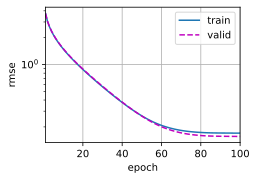

In [ ]:
k, num_epochs, lr, weight_decay, batch_size = 5, 100, 5, 0, 64
train_l, valid_l = k_fold(k, train_features, train_labels, num_epochs, lr,
                          weight_decay, batch_size)
print(f'{k}-折验证: 平均训练log rmse: {float(train_l):f}, '
      f'平均验证log rmse: {float(valid_l):f}')

调我的参数

# 提交kaggle预测

In [210]:
def train_and_pred(net,train_features, test_feature, train_labels, test_data,
                   num_epochs, lr, weight_decay, batch_size):
    train_ls, _ = train(net, train_features, train_labels, None, None,
                        num_epochs, lr, weight_decay, batch_size)
    plot(np.arange(1, num_epochs + 1), [train_ls], xlabel='epoch',
             ylabel='log rmse', xlim=[1, num_epochs], yscale='log')
    print(f'训练log rmse：{float(train_ls[-1]):f}')
    # 将网络应用于测试集。
    preds = net(test_features).detach().numpy()
    # 将其重新格式化以导出到Kaggle
    test_data['SalePrice'] = pd.Series(preds.reshape(1, -1)[0])
    submission = pd.concat([test_data['Id'], test_data['SalePrice']], axis=1)
    submission.to_csv('submission.csv', index=False)

# my net

In [113]:
loss = nn.MSELoss()
# dropout2 = 0.5
in_features = train_features.shape[1]
j_net = nn.Sequential(nn.Flatten(),
        nn.Linear(in_features, 32),
        nn.ReLU(),
        # 在第一个全连接层之后添加一个dropout层
        nn.Linear(32, 1))
'''
def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight, std=0.01)

j_net.apply(init_weights)
'''

'\ndef init_weights(m):\n    if type(m) == nn.Linear:\n        nn.init.normal_(m.weight, std=0.01)\n\nj_net.apply(init_weights)\n'

折1，训练log rmse0.134324, 验证log rmse0.172421
折2，训练log rmse0.125179, 验证log rmse0.143898
折3，训练log rmse0.107961, 验证log rmse0.159633
折4，训练log rmse0.103671, 验证log rmse0.149666
折5，训练log rmse0.102748, 验证log rmse0.119535
折6，训练log rmse0.095784, 验证log rmse0.125927
折7，训练log rmse0.099951, 验证log rmse0.116949
折8，训练log rmse0.088887, 验证log rmse0.119980
8-折验证: 平均训练log rmse: 0.107313, 平均验证log rmse: 0.138501


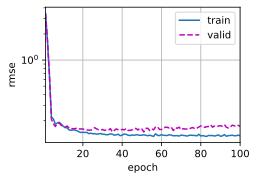

In [87]:
k, num_epochs, lr, weight_decay, batch_size = 8, 100, 0.01, 0, 64
train_l, valid_l = k_fold(j_net, k, train_features, train_labels, num_epochs, lr,
                          weight_decay, batch_size)
print(f'{k}-折验证: 平均训练log rmse: {float(train_l):f}, '
      f'平均验证log rmse: {float(valid_l):f}')

折1，训练log rmse0.171204, 验证log rmse0.166851
折2，训练log rmse0.126534, 验证log rmse0.110395
折3，训练log rmse0.110267, 验证log rmse0.152054
折4，训练log rmse0.106059, 验证log rmse0.130527
折5，训练log rmse0.105684, 验证log rmse0.096885
折6，训练log rmse0.100547, 验证log rmse0.106932
折7，训练log rmse0.096825, 验证log rmse0.093785
折8，训练log rmse0.089738, 验证log rmse0.128495
8-折验证: 平均训练log rmse: 0.113357, 平均验证log rmse: 0.123241


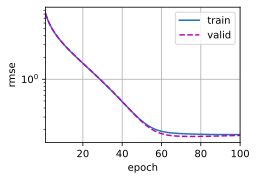

In [114]:
k, num_epochs, lr, weight_decay, batch_size = 8, 100, 0.01, 0.1, 64
train_l, valid_l = k_fold(j_net, k, train_features, train_labels, num_epochs, lr,
                          weight_decay, batch_size)
print(f'{k}-折验证: 平均训练log rmse: {float(train_l):f}, '
      f'平均验证log rmse: {float(valid_l):f}')

折1，训练log rmse0.134985, 验证log rmse0.138402
折2，训练log rmse0.136679, 验证log rmse0.145693
折3，训练log rmse0.131960, 验证log rmse0.141808
折4，训练log rmse0.137356, 验证log rmse0.128556
折5，训练log rmse0.134965, 验证log rmse0.138757
5-折验证: 平均训练log rmse: 0.135189, 平均验证log rmse: 0.138643


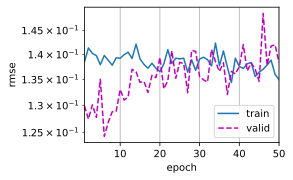

In [108]:
k, num_epochs, lr, weight_decay, batch_size = 5, 50, 0.01, 0, 64
train_l, valid_l = k_fold(j_net, k, train_features, train_labels, num_epochs, lr,
                          weight_decay, batch_size)
print(f'{k}-折验证: 平均训练log rmse: {float(train_l):f}, '
      f'平均验证log rmse: {float(valid_l):f}')

训练log rmse：0.162633


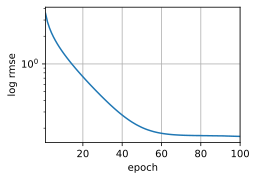

In [ ]:
train_and_pred(train_features, test_features, train_labels, test_data,
               num_epochs, lr, weight_decay, batch_size)

In [198]:
loss = nn.MSELoss()
in_features = train_features.shape[1]
def get_net(num_1,num_2):
  j_net = nn.Sequential(
      nn.Linear(in_features, num_1),
      nn.ReLU(),
      nn.Dropout(0.1),
      nn.Linear(num_1, num_2),
      nn.ReLU(),
      nn.Dropout(0.1),
      nn.Linear(num_2, 1)
      )
  return j_net
  
'''
def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight, std=0.01)

j_net.apply(init_weights)
'''
res = []
Min_loss = 100
for i in range(300,65,-20):
  for j in range(int(i/2),5,-20):
    j_net = get_net(i,j)
    k, num_epochs, lr, weight_decay, batch_size = 5, 30, 0.01, 0, 64
    train_l, valid_l = k_fold(j_net, k, train_features, train_labels, num_epochs, lr,
                          weight_decay, batch_size)
    if valid_l < Min_loss:
      Min_loss = valid_l
      res.append([i,j,Min_loss])
      print(res)
    print(f'第一层神经元个数={i}, 第二层神经元个数={j}\n,  {k}-折验证: 平均训练log rmse: {float(train_l):f}, '
          f'平均验证log rmse: {float(valid_l):f}')

[[300, 150, 0.13973263800144195]]
第一层神经元个数=300, 第二层神经元个数=150
,  5-折验证: 平均训练log rmse: 0.109044, 平均验证log rmse: 0.139733
第一层神经元个数=300, 第二层神经元个数=130
,  5-折验证: 平均训练log rmse: 0.114529, 平均验证log rmse: 0.144498
[[300, 150, 0.13973263800144195], [300, 110, 0.13809941858053207]]
第一层神经元个数=300, 第二层神经元个数=110
,  5-折验证: 平均训练log rmse: 0.113114, 平均验证log rmse: 0.138099
第一层神经元个数=300, 第二层神经元个数=90
,  5-折验证: 平均训练log rmse: 0.118275, 平均验证log rmse: 0.147233
第一层神经元个数=300, 第二层神经元个数=70
,  5-折验证: 平均训练log rmse: 0.125106, 平均验证log rmse: 0.147597
第一层神经元个数=300, 第二层神经元个数=50
,  5-折验证: 平均训练log rmse: 0.131067, 平均验证log rmse: 0.156666
第一层神经元个数=300, 第二层神经元个数=30
,  5-折验证: 平均训练log rmse: 0.152146, 平均验证log rmse: 0.170008
第一层神经元个数=300, 第二层神经元个数=10
,  5-折验证: 平均训练log rmse: 0.240144, 平均验证log rmse: 0.257034
第一层神经元个数=280, 第二层神经元个数=140
,  5-折验证: 平均训练log rmse: 0.116684, 平均验证log rmse: 0.144521
第一层神经元个数=280, 第二层神经元个数=120
,  5-折验证: 平均训练log rmse: 0.116563, 平均验证log rmse: 0.147287
第一层神经元个数=280, 第二层神经元个数=100
,  5-折验证: 平均训练log rmse: 0.122020, 平均验

In [199]:
print(res)

[[300, 150, 0.13973263800144195], [300, 110, 0.13809941858053207]]


In [200]:
j_net = get_net(300,110)

若lay = 1,建议260

In [216]:
num_epochs = 180

折1，训练log rmse0.057698, 验证log rmse0.070171
折2，训练log rmse0.060440, 验证log rmse0.070585
折3，训练log rmse0.058581, 验证log rmse0.072766
折4，训练log rmse0.063514, 验证log rmse0.060256
折5，训练log rmse0.058404, 验证log rmse0.069888


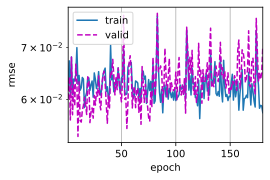

In [217]:
train_l, valid_l = k_fold(j_net, k, train_features, train_labels, num_epochs, lr,
                          weight_decay, batch_size)

训练log rmse：0.059300


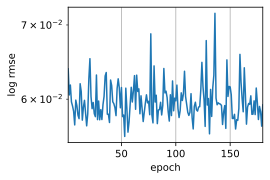

In [219]:
train_and_pred(j_net,train_features, test_features, train_labels, test_data,
               num_epochs, lr, weight_decay, batch_size)